A question I've asked myself repeatedly. It's always interesting when a new deep learning architecture is able to beat the state of the art. The MNIST dataset has 10,000 images in the test set.  At the time of writing Hinton's capsule networks has achieved the state of the art with 0.25% test error.  This translates to 25 misclassified digits.  Not bad at all.  But what do these digits look like?  How does this compare to human performance?

In this blog post I'm going to try to gain some intuition on how good the state of the art is compared to human performance by looking at misclassified MNIST digits using a simple convnet written in keras.

In [1]:
#hide
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

num_classes = 10
img_rows, img_cols = 28, 28

Using TensorFlow backend.


<!-- TEASER_END -->

In [2]:
#hide

def plot_img_grid(imgs, rows, cols):
    h = img_cols
    w = img_rows
    out = np.zeros((rows*h, cols*w), dtype='f')
    i = 0
    for r in range(rows):
        for c in range(cols):
            x_off = c*w
            y_off = r*h
            if i < len(imgs): out[y_off:y_off+h,x_off:x_off+w] = imgs[i].squeeze()
            i+=1
    plt.imshow(out, cmap='gray_r')
    plt.show()


In [3]:
#hide
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


## Model
For the model I'm going to build a simple "off the shelf" convnet (also using batchnorm and dropout).

In [4]:
input_shape = (img_rows,img_cols,1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape, padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [5]:
# hide
batch_size = 128
epochs = 20

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 97us/step - loss: 0.1391 - acc: 0.9587 - val_loss: 0.0373 - val_acc: 0.9869
Epoch 2/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.0496 - acc: 0.9848 - val_loss: 0.0287 - val_acc: 0.9906
Epoch 3/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.0370 - acc: 0.9890 - val_loss: 0.0283 - val_acc: 0.9908
Epoch 4/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0291 - acc: 0.9912 - val_loss: 0.0280 - val_acc: 0.9901
Epoch 5/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0241 - acc: 0.9926 - val_loss: 0.0254 - val_acc: 0.9921
Epoch 6/20
60000/60000 [==============================] - 4s 74us/step - loss: 0.0194 - acc: 0.9942 - val_loss: 0.0235 - val_acc: 0.9927
Epoch 7/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0170 - acc: 0.9950 - val_loss: 0.0231 - val_acc

# Results

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.024712890361214206
Test accuracy: 0.9938


Test error rate of 0.62%.  Not bad for something this simple.  But the question I'm dieing to ask:  What do these digits look like?

Misclassified images that were actually 0


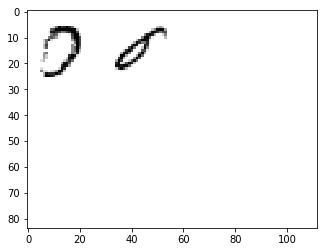

Misclassified images that were actually 1


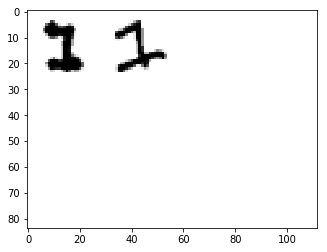

Misclassified images that were actually 2


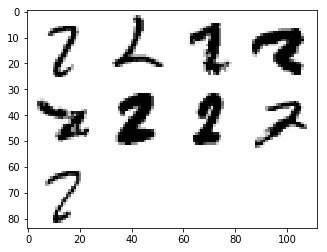

Misclassified images that were actually 3


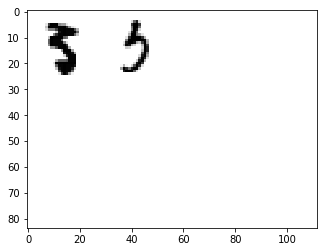

Misclassified images that were actually 4


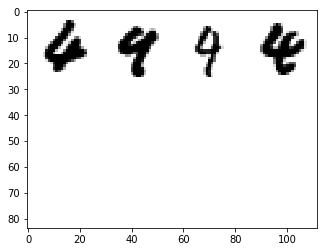

Misclassified images that were actually 5


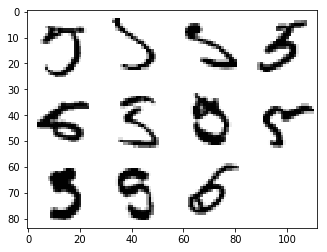

Misclassified images that were actually 6


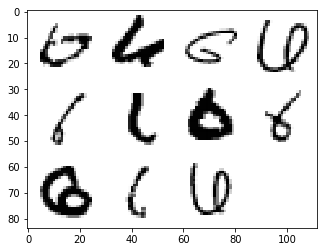

Misclassified images that were actually 7


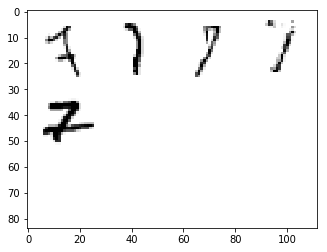

Misclassified images that were actually 8


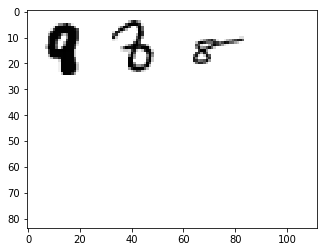

Misclassified images that were actually 9


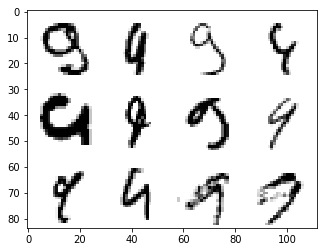

In [13]:
def show_misclassified_digits(X, Y):
    Yp = model.predict(X)
    bad_imgs = [[] for i in range(10)]
    for X0,Y0,Yp0 in zip(X,Y,Yp):
        Y0max = np.argmax(Y0)
        Yp0max = np.argmax(Yp0)
        if Y0max == Yp0max: continue
        bad_imgs[Y0max].append(X0)
    for i in range(10):
        print("Misclassified images that were actually %d" %(i))
        plot_img_grid(bad_imgs[i], 3,4)

show_misclassified_digits(x_test, y_test)

Looking at the digits that were misclassified, I estimate I could probably accurately classify 2/3 of these misclassified digits, but who knows how many digits the model accurately translated that I would fail on.

## What about training digits that were misclassified?
Our model didn't reach 100% accuracy within 20 epochs, presumably due to the regularizing effects of dropout and batch norm.  What do the digits look like that are not correctly classified from the training set?

Misclassified images that were actually 0


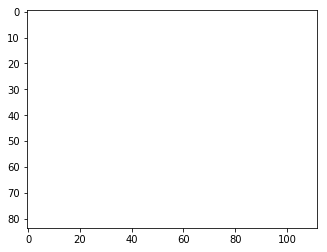

Misclassified images that were actually 1


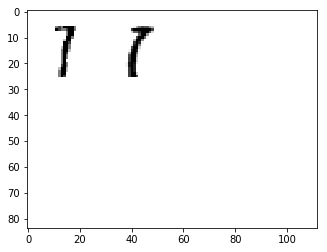

Misclassified images that were actually 2


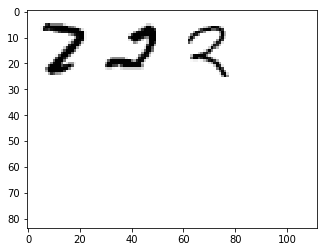

Misclassified images that were actually 3


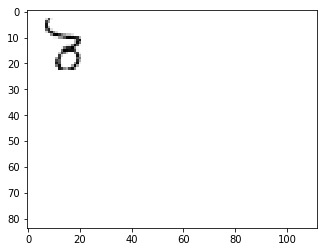

Misclassified images that were actually 4


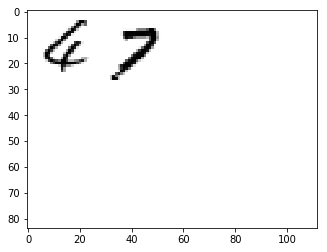

Misclassified images that were actually 5


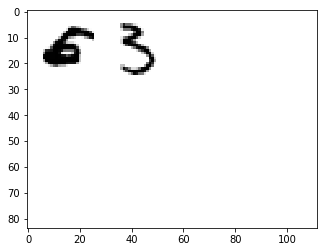

Misclassified images that were actually 6


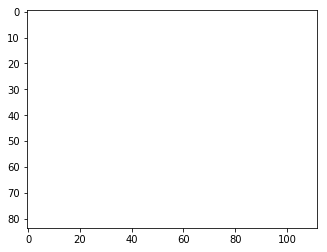

Misclassified images that were actually 7


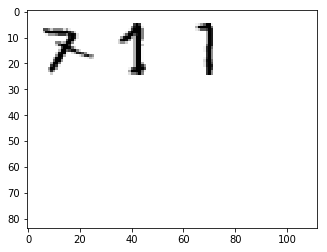

Misclassified images that were actually 8


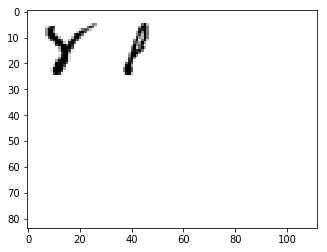

Misclassified images that were actually 9


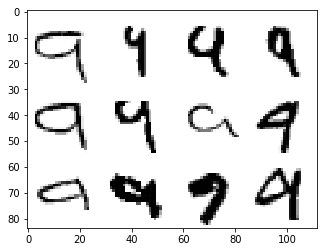

In [14]:
show_misclassified_digits(x_train, y_train)

Interesting!  I suspect that some of these training digits were mislabeled.  I haven't researched the process used to label the dataset, but I have a hard time believing that a human intended to write "4" and it came out looking like that "7".

# Conclusion
Looking at the test digits that were misclassified, I estimate I could probably accurately classify 2/3 of the misclassified digits.  That would imply a best case human error rate of about 0.23%.  But in reality it seems highly unlikely that I'd be able to correctly classify 100% of the test digits the convnet got right, so my real world accuracy is probably a fair bit lower. After this experiment I'm very impressed with the state of the art (0.25%). It seems likely that ML is achieving super human performance on MNIST.

# References
1. http://yann.lecun.com/exdb/mnist/
2. Hinton, Geoffrey E., Sara Sabour, and Nicholas Frosst. "Matrix capsules with EM routing." (2018).
3. https://github.com/fchollet/keras
